In [1]:
import ffsim
from qiskit.circuit import QuantumCircuit, QuantumRegister
from ffsim.variational.util import interaction_pairs_spin_balanced

In [ ]:
norb = 4
n_reps = 2

interaction_pairs = interaction_pairs_spin_balanced("square", norb)

ucj_op = ffsim.random.random_ucj_op_spin_balanced(norb, n_reps=n_reps, interaction_pairs=interaction_pairs)
print(ucj_op)

a = [[[[ 0.00000000e+00,  2.68434250e-02, -0.00000000e+00, -0.00000000e+00],
       [ 2.68434250e-02,  0.00000000e+00, -6.30498331e-01, -0.00000000e+00],
       [-0.00000000e+00, -6.30498331e-01,  0.00000000e+00, 8.22510414e-03],
       [-0.00000000e+00, -0.00000000e+00,  8.22510414e-03, 0.00000000e+00]],

       [[ 4.16985021e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  8.64538599e-01, -0.00000000e+00, 0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  7.31516334e+00, 0.00000000e+00],
        [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.32851809e+01]]]]

UCJOpSpinBalanced(diag_coulomb_mats=array([[[[ 0.00000000e+00,  2.68434250e-02, -0.00000000e+00,
          -0.00000000e+00],
         [ 2.68434250e-02,  0.00000000e+00, -6.30498331e-01,
          -0.00000000e+00],
         [-0.00000000e+00, -6.30498331e-01,  0.00000000e+00,
           8.22510414e-03],
         [-0.00000000e+00, -0.00000000e+00,  8.22510414e-03,
           0.00000000e+00]],

        [[ 4.16985021e+00,  0.00000000e+00, -0.00000000e+00,
          -0.00000000e+00],
         [ 0.00000000e+00,  8.64538599e-01, -0.00000000e+00,
           0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00,  7.31516334e+00,
           0.00000000e+00],
         [-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           1.32851809e+01]]],


       [[[ 0.00000000e+00, -6.32955467e-01,  0.00000000e+00,
          -0.00000000e+00],
         [-6.32955467e-01,  0.00000000e+00, -1.80449165e+00,
          -0.00000000e+00],
         [ 0.00000000e+00, -1.80449165e+00,  0.00000000e+00,
       

In [ ]:
pairs_aa, pairs_ab = interaction_pairs

In [4]:
pairs_aa

[(0, 1), (1, 2), (2, 3)]

In [ ]:
pairs_ab

[(0, 0), (1, 1), (2, 2), (3, 3)]

In [6]:
ucj_op.diag_coulomb_mats.shape

(2, 2, 4, 4)

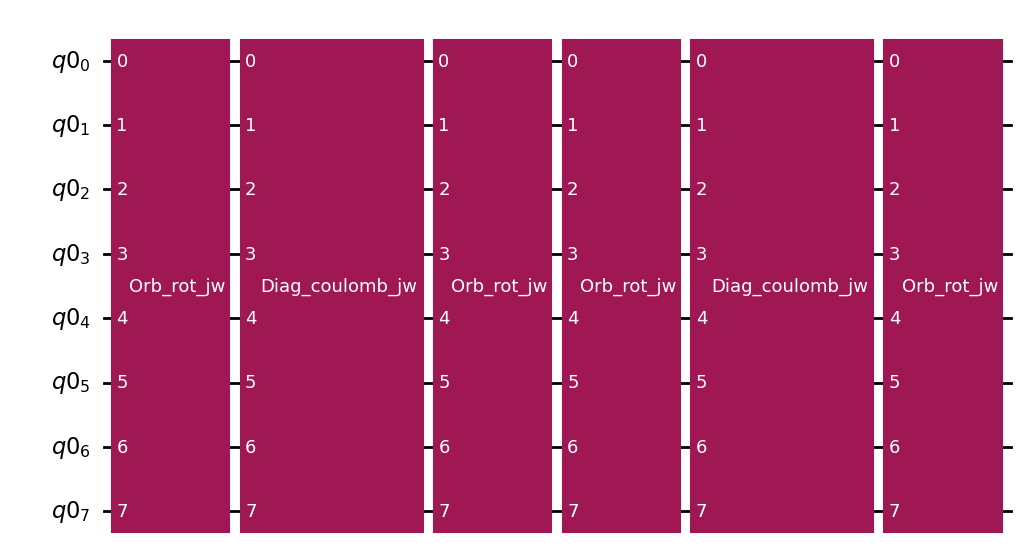

In [7]:
qubits = QuantumRegister(2 * norb)
circuit = QuantumCircuit(qubits)

circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)

circuit.decompose().draw("mpl", fold=-1)

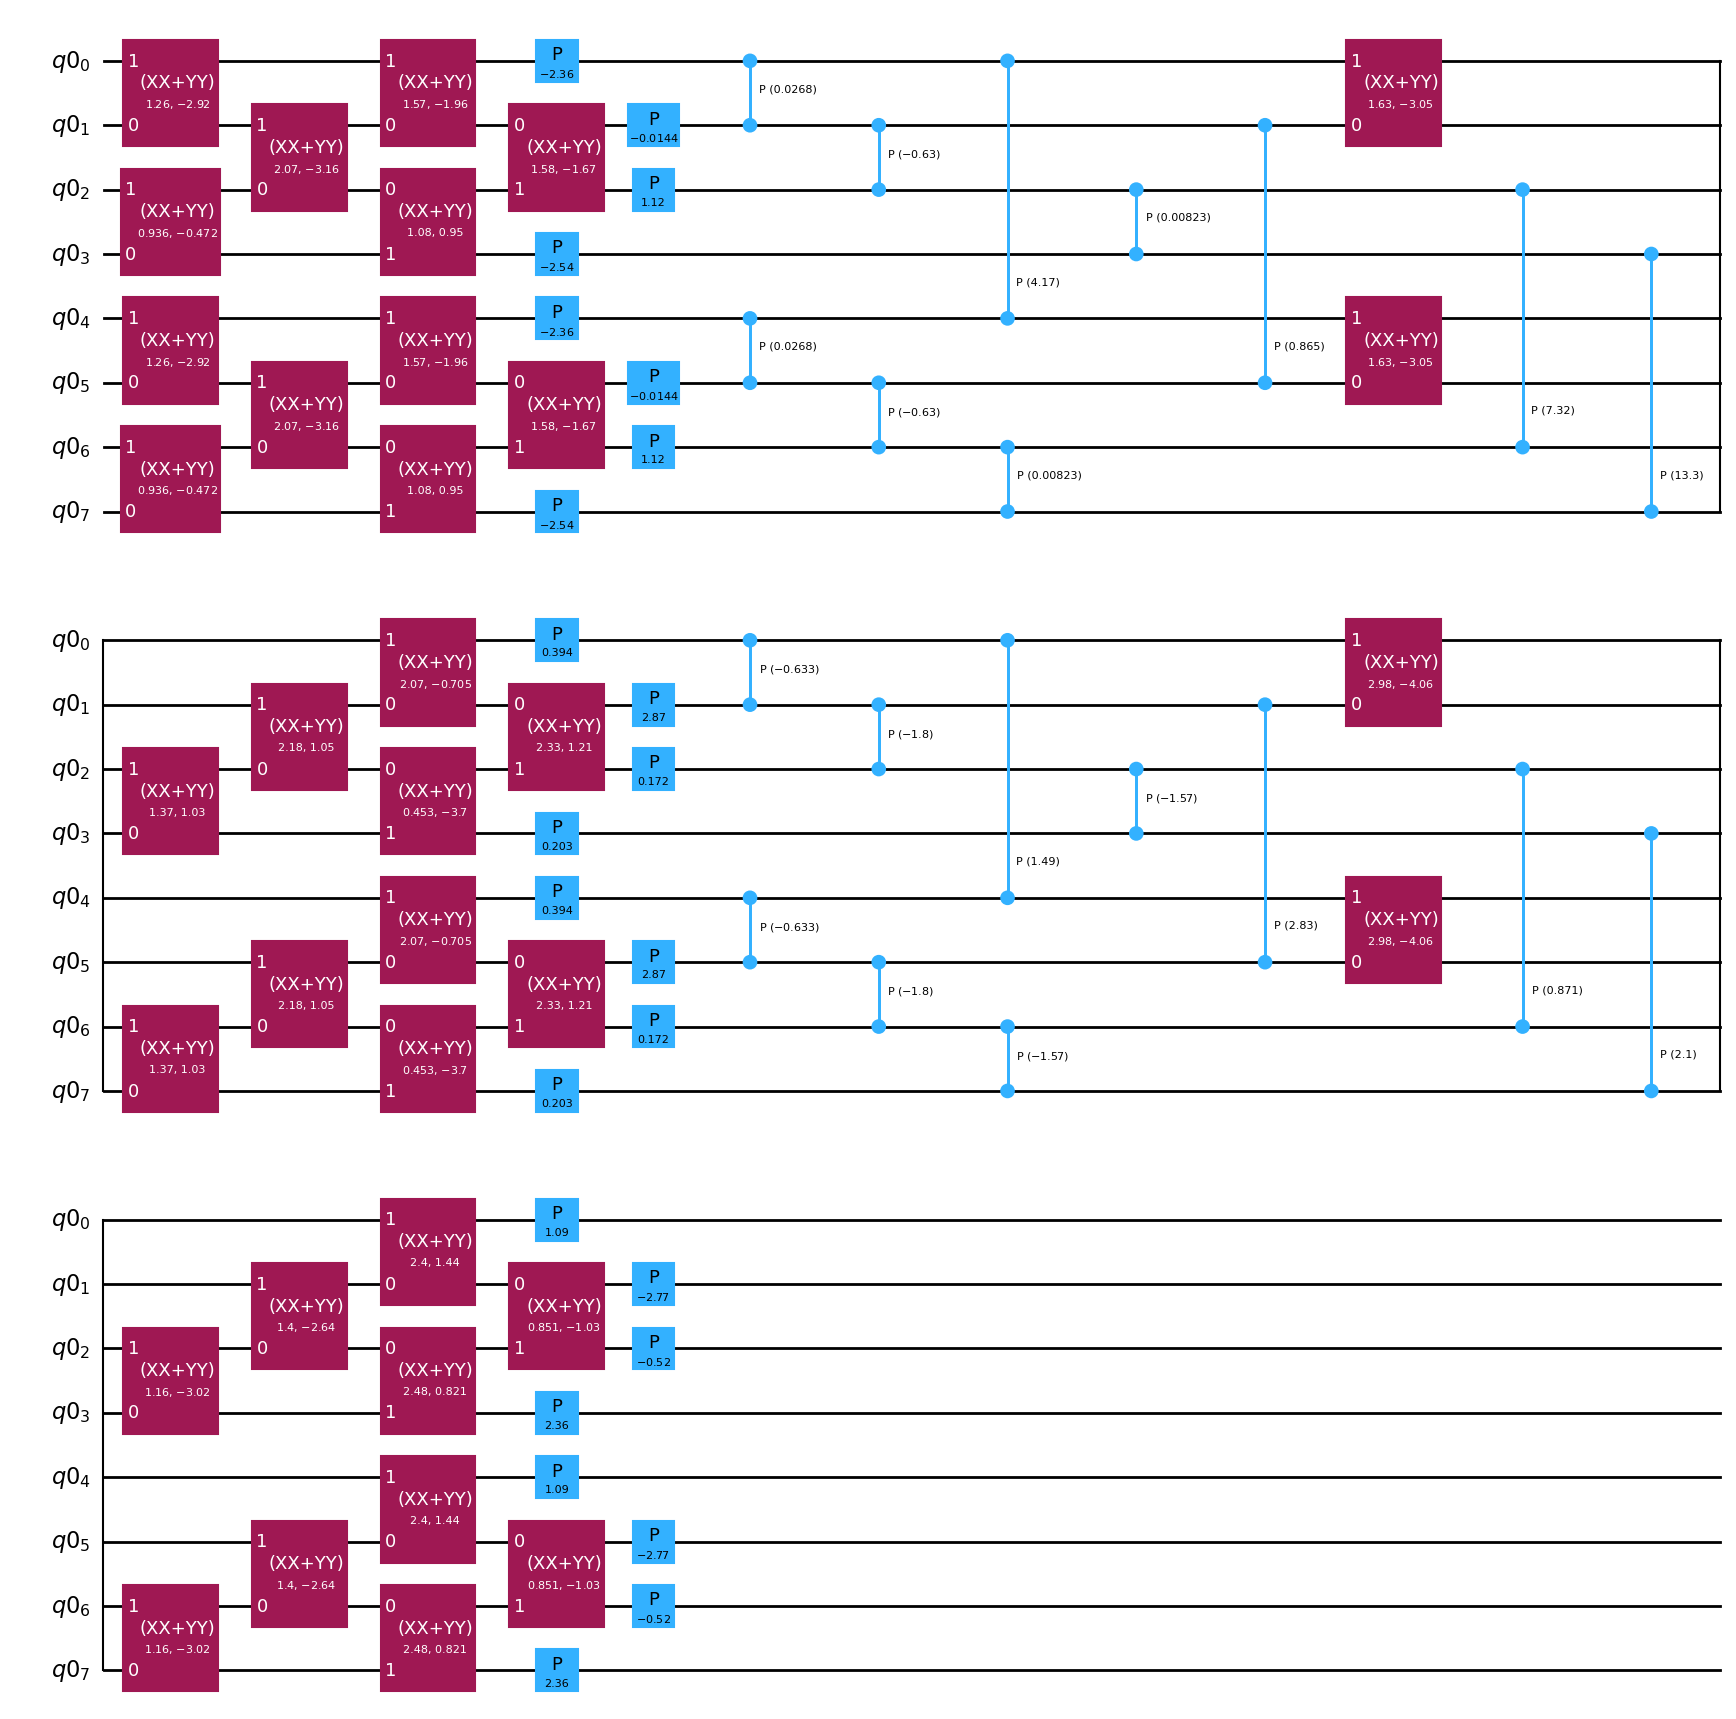

In [8]:
transpiled = ffsim.qiskit.PRE_INIT.run(circuit)

transpiled.decompose().draw("mpl")

In [9]:
def _brickwork(norb: int, n_layers: int):
    for i in range(n_layers):
        for j in range(i % 2, norb - 1, 2):
            yield (j, j + 1)

def _givens_ansatz_jw(
    qubits: Sequence[Qubit], givens_ansatz_op: GivensAnsatzOp
) -> Iterator[CircuitInstruction]:
    phis = givens_ansatz_op.phis
    if phis is None:
        phis = np.zeros(len(givens_ansatz_op.interaction_pairs))
    for (i, j), theta, phi in zip(
        givens_ansatz_op.interaction_pairs, givens_ansatz_op.thetas, phis
    ):
        yield CircuitInstruction(
            XXPlusYYGate(2 * theta, phi - 0.5 * math.pi), (qubits[i], qubits[j])
        )
    if givens_ansatz_op.phase_angles is not None:
        for i, phase_angle in enumerate(givens_ansatz_op.phase_angles):
            yield CircuitInstruction(PhaseGate(phase_angle), (qubits[i],))



def _num_num_ansatz_spin_balanced_jw(
    qubits: Sequence[Qubit], num_num_ansatz_operator: NumNumAnsatzOpSpinBalanced
) -> Iterator[CircuitInstruction]:
    norb = num_num_ansatz_operator.norb
    pairs_aa, pairs_ab = num_num_ansatz_operator.interaction_pairs
    thetas_aa, thetas_ab = num_num_ansatz_operator.thetas

    # gates that involve a single spin sector
    for sigma in range(2):
        for (i, j), theta in zip(pairs_aa, thetas_aa):
            if i == j:
                yield CircuitInstruction(
                    PhaseGate(0.5 * theta), (qubits[i + sigma * norb],)
                )
            else:
                yield CircuitInstruction(
                    CPhaseGate(theta),
                    (qubits[i + sigma * norb], qubits[j + sigma * norb]),
                )

    # gates that involve both spin sectors
    for (i, j), theta in zip(pairs_ab, thetas_ab):
        angle = 0.5 * theta if i == j else theta
        yield CircuitInstruction(CPhaseGate(angle), (qubits[i], qubits[j + norb]))
        yield CircuitInstruction(CPhaseGate(angle), (qubits[j], qubits[i + norb]))


NameError: name 'Sequence' is not defined

In [ ]:
from qiskit.circuit.library import XXPlusYYGate, PhaseGate, CPhaseGate, XGate, GlobalPhaseGate
from qiskit.circuit import ParameterVector, CircuitInstruction, Gate, Qubit
from collections.abc import Iterator, Sequence
import numpy as np
import math

def ucj_spin_balanced_ansatz(
    norb: int,
    nelec: tuple[int, int],
    n_reps: int,
    interaction_pairs: tuple[
        list[tuple[int, int]] | None, list[tuple[int, int]] | None
    ],
) -> QuantumCircuit:
    r"""Gate that prepares the circuit for the Hartree-Fock state (under JWT) from 
        the all zeros state followed by the LUCJ ansatz.

    This gate assumes the Jordan-Wigner transformation (JWT).

    This gate is meant to be applied to the all zeros state. It decomposes simply as
    a sequence of X gates that prepares the Hartree-Fock electronic configuration.

    This gate assumes that qubits are ordered such that the first `norb` qubits
    correspond to the alpha orbitals and the last `norb` qubits correspond to the
    beta orbitals.
    """
    
    qubits = QuantumRegister(2 * norb)
    circuit = QuantumCircuit(qubits)
    pairs_aa, pairs_ab = interaction_pairs

    num_param_per_brickwork = 2 * (norb // 2 + (norb - 1) //2) * (norb // 2) + (norb // 2) * (norb % 2)
    num_param_per_block_orbital_rotation = 2 * num_param_per_brickwork + 2 * norb
    num_param_per_spin_balance = 2 * len(pairs_aa) + len(pairs_ab)
    num_param_simplified_orbital_rotation = 2 * norb + 2 * ((norb - nelec[0]) * nelec[0] + (norb - nelec[1]) * nelec[1])
    
    num_param = num_param_simplified_orbital_rotation + (num_param_per_block_orbital_rotation + num_param_per_spin_balance) * n_reps
    pv = ParameterVector("theta", num_param)
    
    def _add_orbital_rotation(local_pv: ParameterVector):
        for (i, j), id in zip(_brickwork(norb, norb), range(0, num_param_per_brickwork, 2)):
            circuit.append(XXPlusYYGate(local_pv[id], local_pv[id + 1]), [qubits[i], qubits[j]])
            circuit.append(XXPlusYYGate(local_pv[id + num_param_per_brickwork], local_pv[id + num_param_per_brickwork + 1]), [qubits[norb + i], qubits[norb + j]])
        for i, id in zip(range(2 * norb), range(2 * num_param_per_brickwork, 2 * num_param_per_brickwork + 2 * norb)):
            circuit.append(PhaseGate(local_pv[id]), (qubits[i],))
    
    def _add_spin_balance(local_pv: ParameterVector):
        # gates that involve a single spin sector
        for (i, j), id in zip(pairs_aa, range(0, len(pairs_aa))):
            if i == j:
                circuit.append(PhaseGate(local_pv[id]), (qubits[i],))
                circuit.append(PhaseGate(local_pv[id + len(pairs_aa)]), (qubits[i + norb],))
            else:
                circuit.append(CPhaseGate(local_pv[id]),(qubits[i], qubits[j]),)
                circuit.append(CPhaseGate(local_pv[id + len(pairs_aa)]),(qubits[i + norb], qubits[j + norb]),)

        # gates that involve both spin sectors
        for (i, j), id in zip(pairs_ab, range(2 * len(pairs_aa), 2 * len(pairs_aa) + len(pairs_ab))):
            circuit.append(CPhaseGate(local_pv[id]), (qubits[i], qubits[j + norb]))

    # add PrepareHartreeFockJW 
    alpha_qubits = qubits[: norb]
    beta_qubits = qubits[norb :]
    occ_a = range(nelec[0])
    occ_b = range(nelec[1])
    for orb in occ_a:
        circuit.append(XGate(), (alpha_qubits[orb],))
    for orb in occ_b:
        circuit.append(XGate(), (beta_qubits[orb],))

    sign = _permutation_sign(np.argsort(occ_a)) * _permutation_sign(
        np.argsort(occ_b)
    )
    phase = 0 if sign == 1 else math.pi
    circuit.append(GlobalPhaseGate(phase))

    # add the simplified orbital rotation
    pv_id = 0
    for n, local_qubit in zip(nelec, [alpha_qubits, beta_qubits]):
        max_gate_layer = min(n, norb - n)
        start_qubit = n - 1
        num_active_qubit = 2
        factor = 1
        if norb - n < n: 
            factor = -1
        for l in range(max(norb - n, n)):
            for i in range(start_qubit, start_qubit + num_active_qubit, 2):
                circuit.append(XXPlusYYGate(pv[pv_id], pv[pv_id+1]), [local_qubit[i], local_qubit[i+1]])
                pv_id += 2
            if num_active_qubit // 2 < max_gate_layer:
                start_qubit -= 1
                num_active_qubit += 2
            else:
                start_qubit += factor
        if factor == -1:
            start_qubit += 2    
        for l in range(max_gate_layer - 1):
            num_active_qubit -= 2
            for i in range(start_qubit, start_qubit + num_active_qubit, 2):
                circuit.append(XXPlusYYGate(pv[pv_id], pv[pv_id+1]), [local_qubit[i], local_qubit[i+1]])
                pv_id += 2
            start_qubit += 1
    
    for i in range(2 * norb):
        circuit.append(PhaseGate(pv[pv_id + i]), (qubits[i],))
    
    pv_id += (2 * norb)

    for _ in range(n_reps):
        _add_spin_balance(pv[pv_id:])
        pv_id += num_param_per_spin_balance
        _add_orbital_rotation(pv[pv_id:])
        pv_id += num_param_per_block_orbital_rotation
    
    print(len(pv))
    return circuit

def _permutation_sign(perm: np.ndarray) -> int:
    """Compute the sign of a permutation.

    Reference: https://stackoverflow.com/a/73511014
    """
    assert set(perm) == set(range(len(perm)))
    parity = False
    perm = perm.copy()
    for i in range(len(perm)):
        while perm[i] != i:
            parity = not parity
            j = perm[i]
            perm[i], perm[j] = perm[j], perm[i]
    return -1 if parity else 1

136


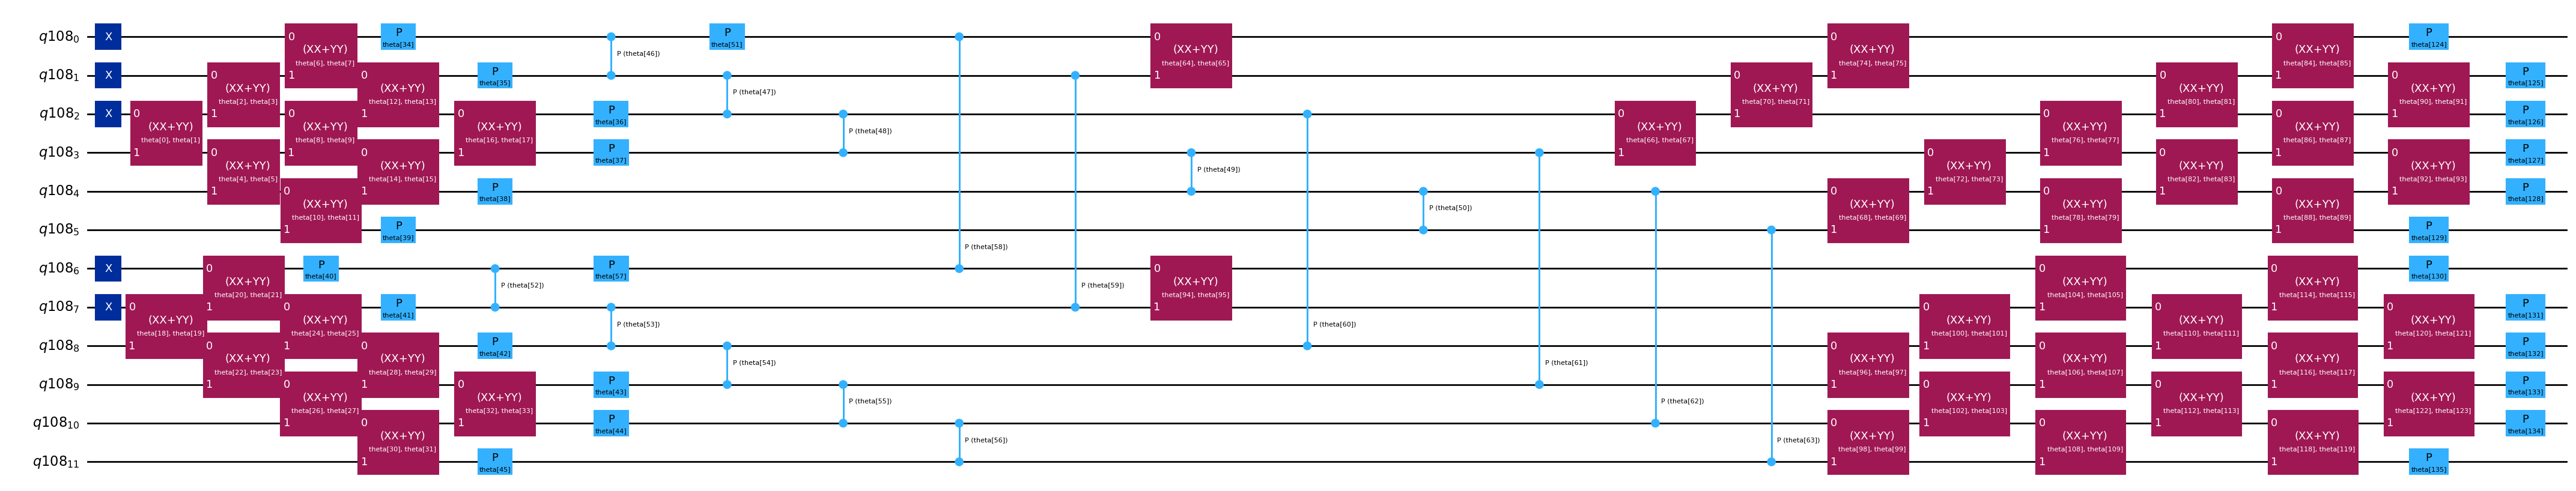

In [ ]:
norb = 6
nelec = (3, 2)
n_reps = 1
pairs_aa = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (0, 0)]
pairs_ab = [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
# interaction_pairs = interaction_pairs_spin_balanced("square", norb)
interaction_pairs = (pairs_aa, pairs_ab)
# (17 + 30) * 2 + 18 + 2 * 12
circuit = ucj_spin_balanced_ansatz(norb, nelec, n_reps=n_reps, interaction_pairs=interaction_pairs)
circuit.draw("mpl", fold=-1)
# circuit.draw("mpl")

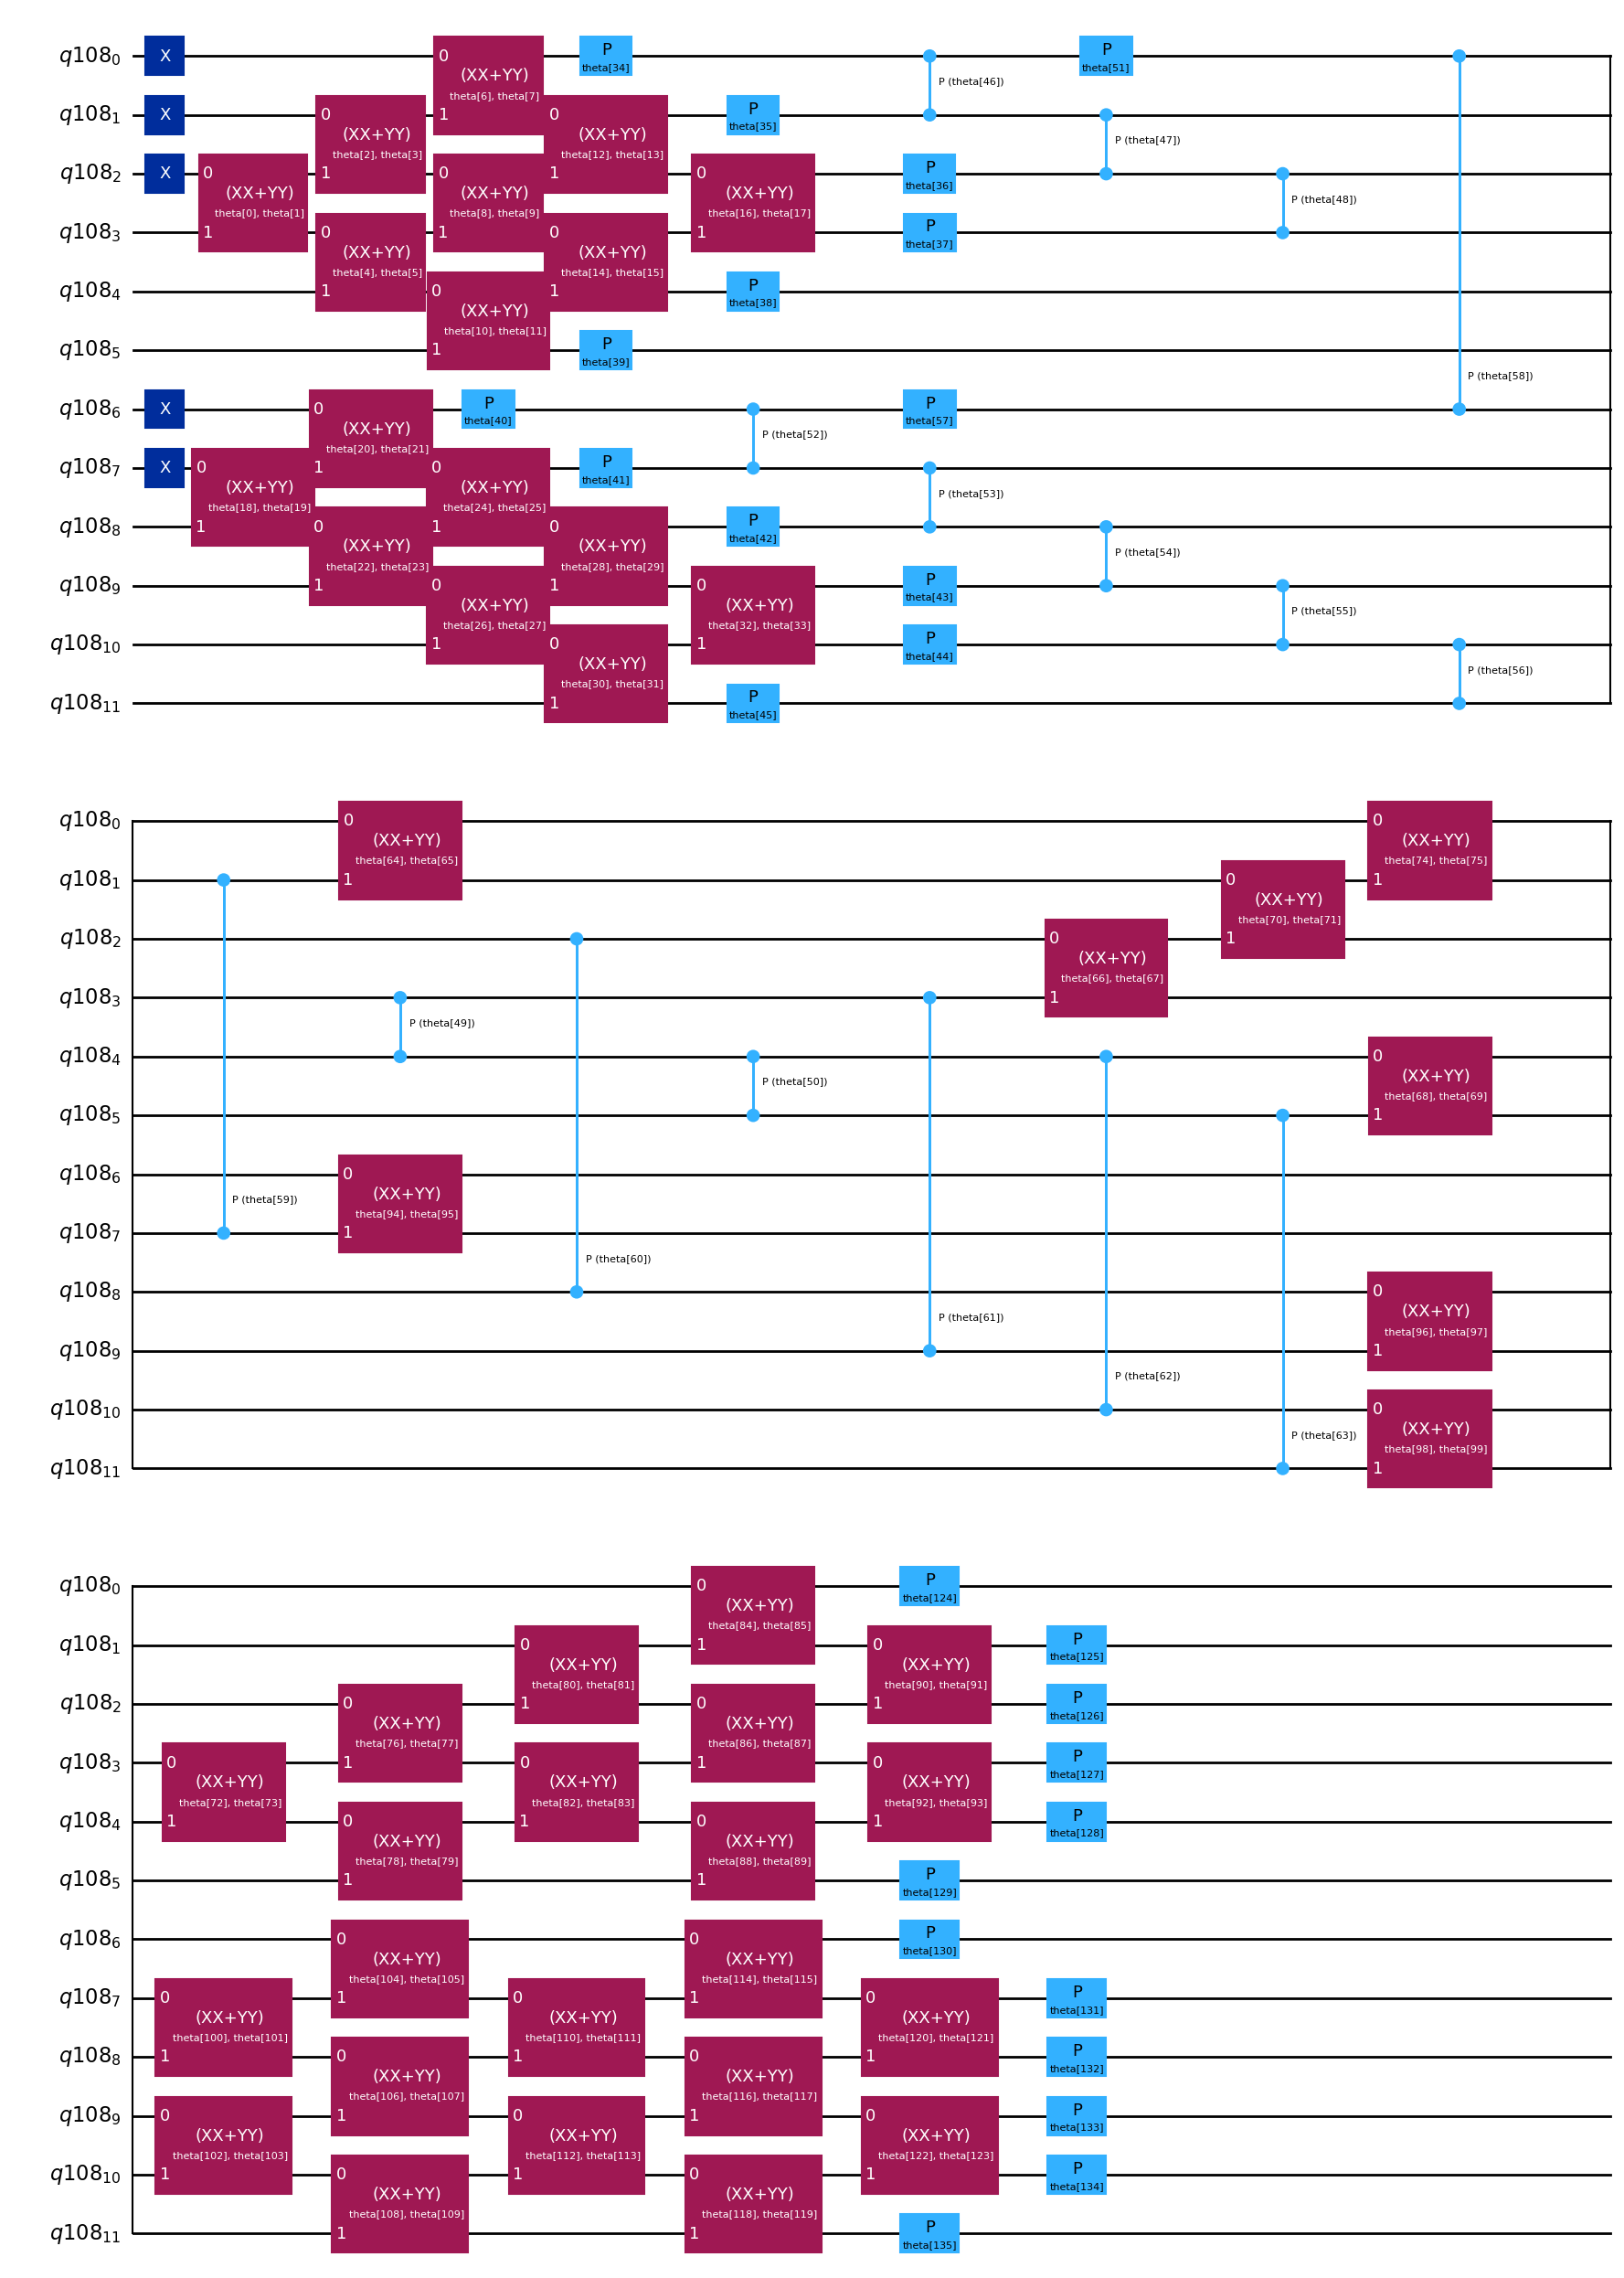

In [207]:
circuit.draw("mpl")

In [210]:
def _permutation_sign(perm: np.ndarray) -> int:
    """Compute the sign of a permutation.

    Reference: https://stackoverflow.com/a/73511014
    """
    assert set(perm) == set(range(len(perm)))
    parity = False
    perm = perm.copy()
    for i in range(len(perm)):
        while perm[i] != i:
            parity = not parity
            j = perm[i]
            perm[i], perm[j] = perm[j], perm[i]
    return -1 if parity else 1

In [214]:
_permutation_sign([2, 1, 3, 0, 4, 5, 6, 7])

1